# 📈 Regime-Aware Portfolio Optimization
This notebook implements a regime-aware Sharpe-maximizing portfolio strategy using sectoral NIFTY returns. It improves upon the basic Markowitz optimization by dynamically adjusting allocations based on detected regimes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load data
data = pd.read_csv("../data/processed/feature_matrix_enriched.csv", parse_dates=['Date'], index_col='Date')

# Ensure numeric
data = data.apply(pd.to_numeric, errors='coerce')
data = data.replace([np.inf, -np.inf], np.nan).dropna()


In [4]:
# Sectors and regime labels
sector_cols = ['NIFTY_IT', 'NIFTY_BANK', 'NIFTY_FMCG', 'NIFTY_PHARMA', 'NIFTY_AUTO', 'NIFTY_METAL']
regime_col = 'gmm_regime'  # Or 'hmm_regime' if preferred


In [5]:
def sharpe_optimizer(mean_returns, cov_matrix, risk_free_rate=0.0):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)

    def neg_sharpe(weights, mean_returns, cov_matrix, risk_free_rate):
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -1 * (port_return - risk_free_rate) / port_vol

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(neg_sharpe, num_assets * [1. / num_assets,], args=args, method='SLSQP',
                      bounds=bounds, constraints=constraints)
    return result.x


In [6]:
regime_weights = {}
regime_returns = {}

for regime in sorted(data[regime_col].unique()):
    sub_df = data[data[regime_col] == regime]
    returns = sub_df[sector_cols].copy()
    returns = returns.replace([np.inf, -np.inf], np.nan).dropna()

    mean_ret = returns.mean() * 252
    cov = returns.cov() * 252

    weights = sharpe_optimizer(mean_ret, cov)
    regime_weights[regime] = weights
    regime_returns[regime] = returns

    ann_return = np.dot(weights, mean_ret)
    ann_vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    sharpe = ann_return / ann_vol

    print(f"--- Regime {regime} ---")
    for sec, w in zip(sector_cols, weights):
        print(f"{sec}: {round(w, 4)}")
    print(f"Expected annual return: {ann_return:.2%}")
    print(f"Annual volatility: {ann_vol:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}\n")


--- Regime 0 ---
NIFTY_IT: 0.0
NIFTY_BANK: 0.0
NIFTY_FMCG: 1.0
NIFTY_PHARMA: 0.0
NIFTY_AUTO: 0.0
NIFTY_METAL: 0.0
Expected annual return: -53.70%
Annual volatility: 17.85%
Sharpe Ratio: -3.01

--- Regime 1 ---
NIFTY_IT: 0.1927
NIFTY_BANK: 0.3401
NIFTY_FMCG: 0.0046
NIFTY_PHARMA: 0.0223
NIFTY_AUTO: 0.1886
NIFTY_METAL: 0.2516
Expected annual return: 59.50%
Annual volatility: 16.92%
Sharpe Ratio: 3.52

--- Regime 2 ---
NIFTY_IT: 0.2837
NIFTY_BANK: 0.1781
NIFTY_FMCG: 0.5199
NIFTY_PHARMA: 0.0183
NIFTY_AUTO: 0.0
NIFTY_METAL: 0.0
Expected annual return: 19.72%
Annual volatility: 9.55%
Sharpe Ratio: 2.07

--- Regime 3 ---
NIFTY_IT: 0.0905
NIFTY_BANK: 0.0
NIFTY_FMCG: 0.0
NIFTY_PHARMA: 0.9095
NIFTY_AUTO: 0.0
NIFTY_METAL: 0.0
Expected annual return: 87.92%
Annual volatility: 40.60%
Sharpe Ratio: 2.17



In [7]:
# Apply regime-based weights dynamically
weights_series = data[regime_col].map(regime_weights)
weights_matrix = np.stack(weights_series)

# Convert returns to numpy
sector_returns = data[sector_cols].values
daily_portfolio_returns = np.sum(weights_matrix * sector_returns, axis=1)

data['regime_portfolio'] = daily_portfolio_returns

# Equal-weighted benchmark
equal_weights = np.ones(len(sector_cols)) / len(sector_cols)
data['equal_portfolio'] = sector_returns.dot(equal_weights)

# Compute cumulative returns
data['regime_cum'] = (1 + data['regime_portfolio']).cumprod()
data['equal_cum'] = (1 + data['equal_portfolio']).cumprod()


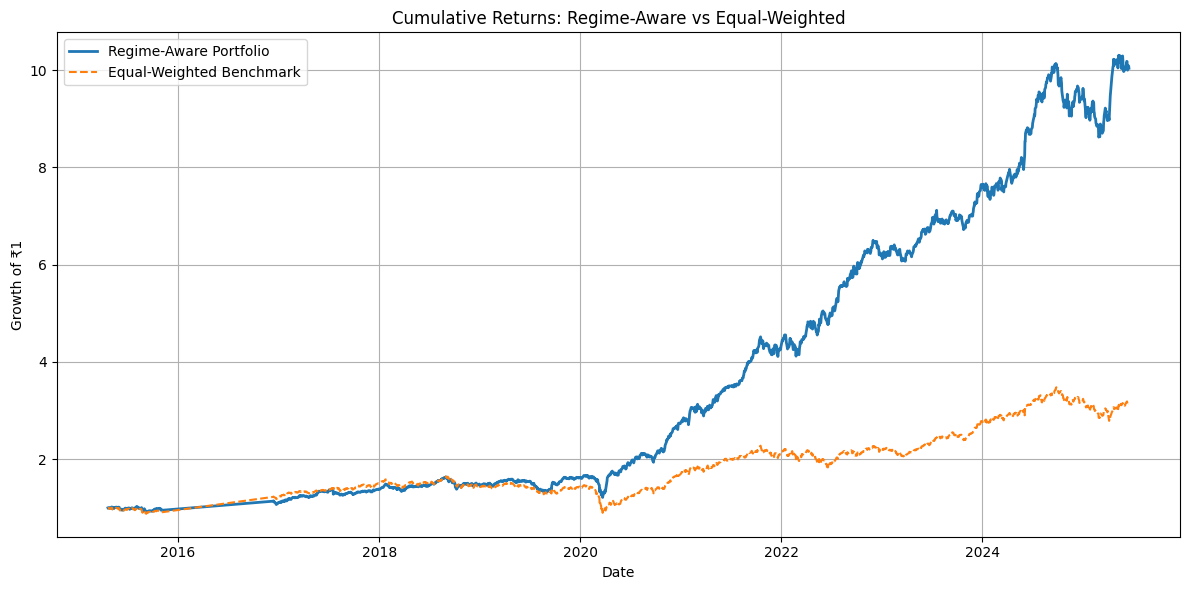

In [8]:
# Plot
plt.figure(figsize=(12,6))
plt.plot(data.index, data['regime_cum'], label='Regime-Aware Portfolio', linewidth=2)
plt.plot(data.index, data['equal_cum'], label='Equal-Weighted Benchmark', linestyle='--')
plt.title("Cumulative Returns: Regime-Aware vs Equal-Weighted")
plt.xlabel("Date")
plt.ylabel("Growth of ₹1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
def metrics(returns):
    cum_return = np.prod(1 + returns) - 1
    ann_return = np.mean(returns) * 252
    ann_vol = np.std(returns) * np.sqrt(252)
    sharpe = ann_return / ann_vol
    max_dd = np.max(np.maximum.accumulate(np.cumprod(1 + returns)) - np.cumprod(1 + returns))
    return cum_return, ann_return, ann_vol, sharpe, max_dd

reg_metrics = metrics(data['regime_portfolio'].dropna())
eq_metrics = metrics(data['equal_portfolio'].dropna())

print("📊 Performance Metrics")
print(f"{'Metric':<25}{'Regime-Aware':>15}{'Equal-Weighted':>20}")
metrics_list = ['Cumulative Return', 'Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown']
for m, r, e in zip(metrics_list, reg_metrics, eq_metrics):
    print(f"{m:<25}{r:>15.2%}{e:>20.2%}")


📊 Performance Metrics
Metric                      Regime-Aware      Equal-Weighted
Cumulative Return                904.11%             212.83%
Annualized Return                 27.90%              14.96%
Annualized Volatility             17.84%              20.32%
Sharpe Ratio                     156.40%              73.66%
Max Drawdown                     151.21%              74.62%
